# Edmonton Metro line project 

## By Jayden Geisler

### Introduction
#### I live in Edmonton Alberta Canada and if you live here too you will know that the LRT system (Light Rail Transit) is not very good for people who live on the east and west side of the city. In this project I attempt to use data of the population and the city to try and plot out the most efficient new LRT line. A new efficient line would value the number of people it reaches and if they will use it as well as the value of the destinations it leads to. The city would have interest in this problem if they where looking to expand the LRT line

### Data
#### I will do this by making 2 data sets. One will be the population of the neighborhoods along with income and education percentage which was attained form the city of Edmonton. The other data set will be venues visited within the neighborhood; this will be obtained through foursquare API. the source of the data is the citu of Edmonton data library

### Methodologyy
#### To solve the problem, I will do two k means on each of the 2 data set. On the venue data set there will be between 3 to 5 clusters and the highest valued cluster will be used as “endpoints” for the new line. For the second data set there will have more clusters, between 8-12 so there are many different values for each neighborhood. Reading a paper for 2017 from the American Public Transportation Association 51% of the people who ride transit hold a bachelor’s degree, for income low - middle income people uses transit the most. After the 2 clusters have been mapped out the center points of the data will be connected through the use of a A-star algorithm that uses both cluster values as a heuristic. 

#### American Public Transportation Association article: https://www.apta.com/wp-content/uploads/Resources/resources/reportsandpublications/Documents/APTA-Who-Rides-Public-Transportation-2017.pdf 


In [1]:
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium 

# Download and Clean up the data set 

Data has been found from city of edmonton website 

neighbourhood location url : https://data.edmonton.ca/City-Administration/City-of-Edmonton-Neighbourhoods-Centroid-Point-/3b6m-fezs

neighbourhood population url : https://data.edmonton.ca/Census/2012-Census-Population-By-Citizenship-Neighbourhoo/nc6t-tngg

neighbourhood income url : https://data.edmonton.ca/Census/2016-Census-Population-by-Household-Income-Neighbo/jkjx-2hix

neighbourhood education url:  https://data.edmonton.ca/Census/2016-Census-Population-by-Highest-Educational-Atta/f7ms-98xd

In [2]:
url = 'C:\Projects\Coursera_Capstone/City_of_Edmonton_-_Neighbourhoods__Centroid_Point_.csv'
df = pd.read_csv(url)
df.head()

,Neighbourhood Number,Neighbourhood Name,Area Sq Km,Latitude,Longitude,Location
0,8886,Edmonton South East,20.424907,53.381222,-113.369114,"(53.38122208627588, -113.3691136163807)"
1,4670,Winterburn Industrial Area West,4.340207,53.562804,-113.701391,"(53.562803614238916, -113.70139052232909)"
2,4487,Secord,2.643762,53.533937,-113.701353,"(53.53393710914364, -113.7013527663504)"
3,4620,Westview Village,0.925300,53.552222,-113.696668,"(53.552222069483065, -113.69666819890175)"
4,6664,Decoteau North,3.750301,53.433217,-113.350674,"(53.43321724004238, -113.350674197389)"


In [3]:
column_names = ['Neighbourhood Number','Neighbourhood','Latitude','Longitude']

edm_hood = pd.DataFrame(columns = column_names)

edm_hood['Neighbourhood Number'] = df['Neighbourhood Number']
edm_hood['Neighbourhood'] = df['Neighbourhood Name']
edm_hood['Latitude'] = df['Latitude']
edm_hood['Longitude'] = df['Longitude']

In [4]:
edm_hood.head()

,Neighbourhood Number,Neighbourhood,Latitude,Longitude
0,8886,Edmonton South East,53.381222,-113.369114
1,4670,Winterburn Industrial Area West,53.562804,-113.701391
2,4487,Secord,53.533937,-113.701353
3,4620,Westview Village,53.552222,-113.696668
4,6664,Decoteau North,53.433217,-113.350674


In [35]:
url = 'C:\Projects\Coursera_Capstone/2012_Census_-_Population_By_Citizenship__Neighbourhood_.csv'
edm_hood_pop = pd.read_csv(url)
edm_hood_pop.head()

,WARD,NEIGHBOURHOOD_NUMBER,NEIGHBOURHOOD NAME,CANADIAN_CITIZEN,NON-CANADIAN_CITIZEN,NO_RESPONSE
0,Ward 1,4010,ALBERTA PARK INDUSTRIAL,0,0,0
1,Ward 1,4020,ALDERGROVE,4756,570,189
2,Ward 1,4011,ANTHONY HENDAY,0,0,0
3,Ward 1,4030,ARMSTRONG INDUSTRIAL,0,0,125
4,Ward 1,4040,BELMEAD,3942,480,181


In [36]:
url = 'C:\Projects\Coursera_Capstone/2016_Census_-_Population_by_Household_Income__Neighbourhood_Ward_.csv'
edm_hood_income = pd.read_csv(url)
edm_hood_income.head()

,Ward,Neighbourhood Number,Neighbourhood Name,"Less than $30,000","$30,000 to less than $60,000","$60,000 to less than $100,000","$100,000 to less than $125,000","$125,000 to less than $150,000","$150,000 to less than $200,000","$200,000 to less than $250,000","$250,000 or more",No Response
0,WARD 1,3140,CRESTWOOD,56,91,90,52,26,58,36,103,404
1,WARD 1,3330,PARKVIEW,51,116,149,93,65,94,60,95,577
2,WARD 5,4220,JAMIESON PLACE,26,71,103,78,64,65,17,13,882
3,WARD 9,5454,RUTHERFORD,130,368,621,334,255,273,99,77,1938
4,WARD 3,2461,CRYSTALLINA NERA EAST,0,0,0,0,0,0,0,0,0


In [37]:
url = 'C:\Projects\Coursera_Capstone/2016_Census_-_Population_by_Highest_Educational_Attainment__Neighbourhood_Ward_.csv'
edm_hood_edu = pd.read_csv(url)
edm_hood_edu.head()

,Ward,Neighbourhood Number,Neighbourhood Name,"No Certificate, Diploma or Degree",High School Diploma or Equivalent,Trades Certificate,Registered Apprenticeship Certificate,College Certificate or Diploma,University Certificate Below Bachelor's Level,Bachelor's Degree,University Certificate or Diploma above Bachelor Level,Medical Degree,Master's Degree,Earned Doctorate,No Response
0,WARD 1,3140,CRESTWOOD,63,280,36,6,256,60,415,61,38,137,42,25
1,WARD 1,3330,PARKVIEW,55,445,75,14,257,67,552,137,58,194,64,141
2,WARD 4,2690,RURAL NORTH EAST SOUTH STURGEON,14,126,24,3,64,14,38,4,1,4,2,42
3,WARD 5,4720,GLASTONBURY,105,692,156,23,624,89,581,75,9,125,25,2218
4,WARD 6,3381,RIVER VALLEY GLENORA,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
#clean up population dataframe where no citizen data is given 
index = 0
for i in edm_hood_pop['CANADIAN_CITIZEN']:
   
    if i == 0 & edm_hood_pop['NON-CANADIAN_CITIZEN'][index] == 0 & edm_hood_pop['NO_RESPONSE'][index] == 0:    
        edm_hood_pop.drop([index],inplace= True)
        
    index += 1

In [39]:
#clean the population dataframe
edm_hood_pop.rename(columns = {'NEIGHBOURHOOD_NUMBER': 'Neighbourhood Number', 'NEIGHBOURHOOD NAME': 'Neighbourhood'}, inplace = True)
edm_hood_pop['Population'] = edm_hood_pop[['CANADIAN_CITIZEN','NON-CANADIAN_CITIZEN','NO_RESPONSE']].sum(axis=1)
edm_hood_pop.drop(columns = ['WARD','CANADIAN_CITIZEN','NON-CANADIAN_CITIZEN','NO_RESPONSE'],inplace = True)

In [40]:
edm_hood_pop.reset_index()

,index,Neighbourhood Number,Neighbourhood,Population
0,1,4020,ALDERGROVE,5515
1,4,4040,BELMEAD,4603
2,5,4700,BRECKENRIDGE GREENS,1911
3,6,4060,BRITANNIA YOUNGSTOWN,4759
4,7,4090,CANORA,3335
...,...,...,...,...
255,369,6213,SUMMERSIDE,7976
256,370,6443,TAMARACK,2348
257,372,6662,WALKER,2036
258,373,6770,WEINLOS,3445


In [41]:
#clan up income data if no data given of income data set 
index = 0
for i in edm_hood_income['Less than $30,000']:
   
    if i == 0 & edm_hood_income['$60,000 to less than $100,000'][index] == 0 & edm_hood_income['$200,000 to less than $250,000'][index] == 0:    
        edm_hood_income.drop([index],inplace= True)
        
    index += 1

In [42]:
edm_hood_income.reset_index()

,index,Ward,Neighbourhood Number,Neighbourhood Name,"Less than $30,000","$30,000 to less than $60,000","$60,000 to less than $100,000","$100,000 to less than $125,000","$125,000 to less than $150,000","$150,000 to less than $200,000","$200,000 to less than $250,000","$250,000 or more",No Response
0,0,WARD 1,3140,CRESTWOOD,56,91,90,52,26,58,36,103,404
1,1,WARD 1,3330,PARKVIEW,51,116,149,93,65,94,60,95,577
2,2,WARD 5,4220,JAMIESON PLACE,26,71,103,78,64,65,17,13,882
3,3,WARD 9,5454,RUTHERFORD,130,368,621,334,255,273,99,77,1938
4,5,WARD 11,6470,MEYONOHK,47,138,156,62,23,28,8,0,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,381,WARD 10,5430,ROYAL GARDENS,121,199,224,68,31,38,19,7,695
264,382,WARD 10,5180,ERMINESKIN,367,531,322,94,60,45,28,11,986
265,383,WARD 7,2040,BEACON HEIGHTS,142,152,190,62,33,24,6,3,591
266,385,WARD 2,3480,HUDSON,21,98,163,63,32,31,4,15,373


In [43]:
# make less columns, combinne and make the numbers a percentage 
cols = edm_hood_income.columns
colslist = list(cols)
print(colslist[3:])
edm_hood_income['total'] = edm_hood_income[colslist[3:]].sum(axis=1)
edm_hood_income


['Less than $30,000', '$30,000 to less than $60,000', '$60,000 to less than $100,000', '$100,000 to less than $125,000', '$125,000 to less than $150,000', '$150,000 to less than $200,000', '$200,000 to less than $250,000', '$250,000 or more', 'No Response']


,Ward,Neighbourhood Number,Neighbourhood Name,"Less than $30,000","$30,000 to less than $60,000","$60,000 to less than $100,000","$100,000 to less than $125,000","$125,000 to less than $150,000","$150,000 to less than $200,000","$200,000 to less than $250,000","$250,000 or more",No Response,total
0,WARD 1,3140,CRESTWOOD,56,91,90,52,26,58,36,103,404,916
1,WARD 1,3330,PARKVIEW,51,116,149,93,65,94,60,95,577,1300
2,WARD 5,4220,JAMIESON PLACE,26,71,103,78,64,65,17,13,882,1319
3,WARD 9,5454,RUTHERFORD,130,368,621,334,255,273,99,77,1938,4095
5,WARD 11,6470,MEYONOHK,47,138,156,62,23,28,8,0,650,1112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,WARD 10,5430,ROYAL GARDENS,121,199,224,68,31,38,19,7,695,1402
382,WARD 10,5180,ERMINESKIN,367,531,322,94,60,45,28,11,986,2444
383,WARD 7,2040,BEACON HEIGHTS,142,152,190,62,33,24,6,3,591,1203
385,WARD 2,3480,HUDSON,21,98,163,63,32,31,4,15,373,800


In [44]:
edm_hood_income['Less than $60,000'] = edm_hood_income[['Less than $30,000','$30,000 to less than $60,000']].sum(axis=1)/edm_hood_income['total']
edm_hood_income['$60,000 to $125,000'] = edm_hood_income[['$60,000 to less than $100,000','$100,000 to less than $125,000']].sum(axis=1)/edm_hood_income['total']
edm_hood_income['$125,000 to $200,000'] = edm_hood_income[['$125,000 to less than $150,000','$150,000 to less than $200,000']].sum(axis=1)/edm_hood_income['total']
edm_hood_income['$200,000 or more'] = edm_hood_income[['$200,000 to less than $250,000','$250,000 or more']].sum(axis=1)/edm_hood_income['total']
edm_hood_income['No Response income'] = edm_hood_income['No Response']/edm_hood_income['total']
edm_hood_income

,Ward,Neighbourhood Number,Neighbourhood Name,"Less than $30,000","$30,000 to less than $60,000","$60,000 to less than $100,000","$100,000 to less than $125,000","$125,000 to less than $150,000","$150,000 to less than $200,000","$200,000 to less than $250,000","$250,000 or more",No Response,total,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more",No Response income
0,WARD 1,3140,CRESTWOOD,56,91,90,52,26,58,36,103,404,916,0.160480,0.155022,0.091703,0.151747,0.441048
1,WARD 1,3330,PARKVIEW,51,116,149,93,65,94,60,95,577,1300,0.128462,0.186154,0.122308,0.119231,0.443846
2,WARD 5,4220,JAMIESON PLACE,26,71,103,78,64,65,17,13,882,1319,0.073541,0.137225,0.097801,0.022745,0.668688
3,WARD 9,5454,RUTHERFORD,130,368,621,334,255,273,99,77,1938,4095,0.121612,0.233211,0.128938,0.042979,0.473260
5,WARD 11,6470,MEYONOHK,47,138,156,62,23,28,8,0,650,1112,0.166367,0.196043,0.045863,0.007194,0.584532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,WARD 10,5430,ROYAL GARDENS,121,199,224,68,31,38,19,7,695,1402,0.228245,0.208274,0.049215,0.018545,0.495720
382,WARD 10,5180,ERMINESKIN,367,531,322,94,60,45,28,11,986,2444,0.367430,0.170213,0.042962,0.015957,0.403437
383,WARD 7,2040,BEACON HEIGHTS,142,152,190,62,33,24,6,3,591,1203,0.244389,0.209476,0.047382,0.007481,0.491272
385,WARD 2,3480,HUDSON,21,98,163,63,32,31,4,15,373,800,0.148750,0.282500,0.078750,0.023750,0.466250


In [45]:
colstodrop = ['Ward','Less than $30,000','$30,000 to less than $60,000', '$60,000 to less than $100,000', '$100,000 to less than $125,000', '$125,000 to less than $150,000', '$150,000 to less than $200,000', '$200,000 to less than $250,000', '$250,000 or more','total','No Response']
edm_hood_income.drop(colstodrop, axis = 1,inplace = True)

In [46]:
edm_hood_income.reset_index()

,index,Neighbourhood Number,Neighbourhood Name,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more",No Response income
0,0,3140,CRESTWOOD,0.160480,0.155022,0.091703,0.151747,0.441048
1,1,3330,PARKVIEW,0.128462,0.186154,0.122308,0.119231,0.443846
2,2,4220,JAMIESON PLACE,0.073541,0.137225,0.097801,0.022745,0.668688
3,3,5454,RUTHERFORD,0.121612,0.233211,0.128938,0.042979,0.473260
4,5,6470,MEYONOHK,0.166367,0.196043,0.045863,0.007194,0.584532
...,...,...,...,...,...,...,...,...
263,381,5430,ROYAL GARDENS,0.228245,0.208274,0.049215,0.018545,0.495720
264,382,5180,ERMINESKIN,0.367430,0.170213,0.042962,0.015957,0.403437
265,383,2040,BEACON HEIGHTS,0.244389,0.209476,0.047382,0.007481,0.491272
266,385,3480,HUDSON,0.148750,0.282500,0.078750,0.023750,0.466250


In [47]:
#clean up education if no data is given education data set 
index = 0
for i in edm_hood_edu['No Certificate, Diploma or Degree']:
   
    if i == 0 & edm_hood_edu['High School Diploma or Equivalent'][index] == 0 & edm_hood_edu["Bachelor\'s Degree"][index] == 0:    
        edm_hood_edu.drop([index],inplace= True)
        
    index += 1

In [48]:
edm_hood_edu.reset_index()

,index,Ward,Neighbourhood Number,Neighbourhood Name,"No Certificate, Diploma or Degree",High School Diploma or Equivalent,Trades Certificate,Registered Apprenticeship Certificate,College Certificate or Diploma,University Certificate Below Bachelor's Level,Bachelor's Degree,University Certificate or Diploma above Bachelor Level,Medical Degree,Master's Degree,Earned Doctorate,No Response
0,0,WARD 1,3140,CRESTWOOD,63,280,36,6,256,60,415,61,38,137,42,25
1,1,WARD 1,3330,PARKVIEW,55,445,75,14,257,67,552,137,58,194,64,141
2,2,WARD 4,2690,RURAL NORTH EAST SOUTH STURGEON,14,126,24,3,64,14,38,4,1,4,2,42
3,3,WARD 5,4720,GLASTONBURY,105,692,156,23,624,89,581,75,9,125,25,2218
4,6,WARD 1,4060,BRITANNIA YOUNGSTOWN,261,658,119,9,343,56,210,22,1,46,0,843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,378,WARD 3,3180,DUNLUCE,225,869,216,17,538,102,300,31,3,41,7,2008
270,380,WARD 3,2511,MAYLIEWAN,135,523,130,7,286,117,142,50,8,30,8,1272
271,381,WARD 2,3250,KENSINGTON,214,485,106,12,241,29,132,16,0,26,2,1060
272,384,WARD 4,2710,SIFTON PARK,49,113,26,6,72,25,29,11,2,10,1,482


In [49]:
# make less columns, combinne and make the numbers a percentage 
cols = edm_hood_edu.columns
colslist = list(cols)
print(colslist[3:])
edm_hood_edu['total'] = edm_hood_edu[colslist[3:]].sum(axis=1)
edm_hood_edu

['No Certificate, Diploma or Degree', 'High School Diploma or Equivalent', 'Trades Certificate', 'Registered Apprenticeship Certificate', 'College Certificate or Diploma', "University Certificate Below Bachelor's Level", "Bachelor's Degree", 'University Certificate or Diploma above Bachelor Level', 'Medical Degree', "Master's Degree", 'Earned Doctorate', 'No Response']


,Ward,Neighbourhood Number,Neighbourhood Name,"No Certificate, Diploma or Degree",High School Diploma or Equivalent,Trades Certificate,Registered Apprenticeship Certificate,College Certificate or Diploma,University Certificate Below Bachelor's Level,Bachelor's Degree,University Certificate or Diploma above Bachelor Level,Medical Degree,Master's Degree,Earned Doctorate,No Response,total
0,WARD 1,3140,CRESTWOOD,63,280,36,6,256,60,415,61,38,137,42,25,1419
1,WARD 1,3330,PARKVIEW,55,445,75,14,257,67,552,137,58,194,64,141,2059
2,WARD 4,2690,RURAL NORTH EAST SOUTH STURGEON,14,126,24,3,64,14,38,4,1,4,2,42,336
3,WARD 5,4720,GLASTONBURY,105,692,156,23,624,89,581,75,9,125,25,2218,4722
6,WARD 1,4060,BRITANNIA YOUNGSTOWN,261,658,119,9,343,56,210,22,1,46,0,843,2568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,WARD 3,3180,DUNLUCE,225,869,216,17,538,102,300,31,3,41,7,2008,4357
380,WARD 3,2511,MAYLIEWAN,135,523,130,7,286,117,142,50,8,30,8,1272,2708
381,WARD 2,3250,KENSINGTON,214,485,106,12,241,29,132,16,0,26,2,1060,2323
384,WARD 4,2710,SIFTON PARK,49,113,26,6,72,25,29,11,2,10,1,482,826


In [50]:
#combine a few columns and make them a percentage 
edm_hood_edu['High School Diploma or below'] = edm_hood_edu[['High School Diploma or Equivalent','No Certificate, Diploma or Degree']].sum(axis=1)/edm_hood_edu['total']

edm_hood_edu['Trades, College Certificate or Diploma'] = edm_hood_edu[['Trades Certificate', 'Registered Apprenticeship Certificate', 'College Certificate or Diploma', "University Certificate Below Bachelor's Level"]].sum(axis=1)/edm_hood_edu['total']

edm_hood_edu['University Degree'] = edm_hood_edu[["Bachelor's Degree", 'University Certificate or Diploma above Bachelor Level']].sum(axis=1)/edm_hood_edu['total']

edm_hood_edu['Medical degree, Master\'s or Doctorate'] = edm_hood_edu[['Medical Degree', "Master's Degree", 'Earned Doctorate']].sum(axis=1)/edm_hood_edu['total']

edm_hood_edu['No Response education'] = edm_hood_edu['No Response']/edm_hood_edu['total']

edm_hood_edu

,Ward,Neighbourhood Number,Neighbourhood Name,"No Certificate, Diploma or Degree",High School Diploma or Equivalent,Trades Certificate,Registered Apprenticeship Certificate,College Certificate or Diploma,University Certificate Below Bachelor's Level,Bachelor's Degree,...,Medical Degree,Master's Degree,Earned Doctorate,No Response,total,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate",No Response education
0,WARD 1,3140,CRESTWOOD,63,280,36,6,256,60,415,...,38,137,42,25,1419,0.241720,0.252290,0.335447,0.152925,0.017618
1,WARD 1,3330,PARKVIEW,55,445,75,14,257,67,552,...,58,194,64,141,2059,0.242836,0.200583,0.334628,0.153473,0.068480
2,WARD 4,2690,RURAL NORTH EAST SOUTH STURGEON,14,126,24,3,64,14,38,...,1,4,2,42,336,0.416667,0.312500,0.125000,0.020833,0.125000
3,WARD 5,4720,GLASTONBURY,105,692,156,23,624,89,581,...,9,125,25,2218,4722,0.168784,0.188903,0.138924,0.033672,0.469716
6,WARD 1,4060,BRITANNIA YOUNGSTOWN,261,658,119,9,343,56,210,...,1,46,0,843,2568,0.357866,0.205218,0.090343,0.018302,0.328271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,WARD 3,3180,DUNLUCE,225,869,216,17,538,102,300,...,3,41,7,2008,4357,0.251090,0.200367,0.075970,0.011705,0.460868
380,WARD 3,2511,MAYLIEWAN,135,523,130,7,286,117,142,...,8,30,8,1272,2708,0.242984,0.199409,0.070901,0.016987,0.469719
381,WARD 2,3250,KENSINGTON,214,485,106,12,241,29,132,...,0,26,2,1060,2323,0.300904,0.167025,0.063711,0.012053,0.456307
384,WARD 4,2710,SIFTON PARK,49,113,26,6,72,25,29,...,2,10,1,482,826,0.196126,0.156174,0.048426,0.015738,0.583535


In [51]:
colstodrop = ['Ward','No Certificate, Diploma or Degree', 'High School Diploma or Equivalent', 'Trades Certificate', 'Registered Apprenticeship Certificate', 'College Certificate or Diploma', "University Certificate Below Bachelor's Level", "Bachelor's Degree", 'University Certificate or Diploma above Bachelor Level', 'Medical Degree', "Master's Degree", 'Earned Doctorate', 'total','No Response']
edm_hood_edu.drop(colstodrop, axis = 1,inplace = True)

In [52]:
edm_hood_edu.reset_index()

,index,Neighbourhood Number,Neighbourhood Name,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate",No Response education
0,0,3140,CRESTWOOD,0.241720,0.252290,0.335447,0.152925,0.017618
1,1,3330,PARKVIEW,0.242836,0.200583,0.334628,0.153473,0.068480
2,2,2690,RURAL NORTH EAST SOUTH STURGEON,0.416667,0.312500,0.125000,0.020833,0.125000
3,3,4720,GLASTONBURY,0.168784,0.188903,0.138924,0.033672,0.469716
4,6,4060,BRITANNIA YOUNGSTOWN,0.357866,0.205218,0.090343,0.018302,0.328271
...,...,...,...,...,...,...,...,...
269,378,3180,DUNLUCE,0.251090,0.200367,0.075970,0.011705,0.460868
270,380,2511,MAYLIEWAN,0.242984,0.199409,0.070901,0.016987,0.469719
271,381,3250,KENSINGTON,0.300904,0.167025,0.063711,0.012053,0.456307
272,384,2710,SIFTON PARK,0.196126,0.156174,0.048426,0.015738,0.583535


In [53]:
#missing neighbourhoods 
print(edm_hood.shape)
print(edm_hood_pop.shape)
print(edm_hood_edu.shape)
print(edm_hood_income.shape)

(400, 4)
(260, 3)
(274, 7)
(268, 7)


In [54]:
edm_hood

,Neighbourhood Number,Neighbourhood,Latitude,Longitude
0,8886,Edmonton South East,53.381222,-113.369114
1,4670,Winterburn Industrial Area West,53.562804,-113.701391
2,4487,Secord,53.533937,-113.701353
3,4620,Westview Village,53.552222,-113.696668
4,6664,Decoteau North,53.433217,-113.350674
...,...,...,...,...
395,1270,Yellowhead Corridor East,53.579205,-113.451964
396,3450,Woodcroft,53.564595,-113.558327
397,6680,Satoo,53.446373,-113.458892
398,3050,Brown Industrial,53.582399,-113.568007


In [55]:
edm_hood_pop

,Neighbourhood Number,Neighbourhood,Population
1,4020,ALDERGROVE,5515
4,4040,BELMEAD,4603
5,4700,BRECKENRIDGE GREENS,1911
6,4060,BRITANNIA YOUNGSTOWN,4759
7,4090,CANORA,3335
...,...,...,...
369,6213,SUMMERSIDE,7976
370,6443,TAMARACK,2348
372,6662,WALKER,2036
373,6770,WEINLOS,3445


In [69]:
merged_edm_data1 = pd.merge(left = edm_hood, right = edm_hood_pop, left_on = 'Neighbourhood Number', right_on = 'Neighbourhood Number')
merged_edm_data2 = pd.merge(left = edm_hood_edu, right = edm_hood_income, left_on = 'Neighbourhood Number', right_on = 'Neighbourhood Number')

In [70]:
edm_hood_total = pd.merge(left = merged_edm_data1, right = merged_edm_data2, left_on = 'Neighbourhood Number', right_on = 'Neighbourhood Number')

In [74]:
# remove neighbouthood columns 
edm_hood_total.rename(columns = {'Neighbourhood_x': 'Neighbourhood Name'}, inplace = True)
edm_hood_total.drop(['Neighbourhood_y','Neighbourhood Name_x','Neighbourhood Name_y'],axis = 1,inplace = True)

In [75]:
edm_hood_total

,Neighbourhood Number,Neighbourhood Name,Latitude,Longitude,Population,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate",No Response education,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more",No Response income
0,4487,Secord,53.533937,-113.701353,914,0.332569,0.209174,0.150917,0.037615,0.269725,0.323894,0.198230,0.131858,0.030973,0.315044
1,4620,Westview Village,53.552222,-113.696668,2242,0.638655,0.307773,0.025210,0.004202,0.024160,0.197507,0.124640,0.021093,0.000959,0.655801
2,5462,Chappelle Area,53.402917,-113.586845,151,0.054283,0.086359,0.082129,0.027141,0.750088,0.074909,0.263094,0.129111,0.033496,0.499391
3,2670,Rural North East Horse Hill,53.678364,-113.312512,570,0.048499,0.013857,0.032333,0.004619,0.900693,0.056338,0.028169,0.021127,0.028169,0.866197
4,6790,Wild Rose,53.470564,-113.381167,8031,0.223929,0.155859,0.101631,0.031475,0.487107,0.094262,0.163115,0.080328,0.021311,0.640984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,3170,Dovercourt,53.575727,-113.559534,2048,0.409021,0.337920,0.152141,0.042049,0.058869,0.255196,0.284065,0.107390,0.024249,0.329099
245,5300,Ogilvie Ridge,53.464904,-113.567069,1001,0.146628,0.170088,0.222874,0.151026,0.309384,0.038889,0.108333,0.086111,0.175000,0.591667
246,3450,Woodcroft,53.564595,-113.558327,2598,0.230570,0.170337,0.102332,0.032383,0.464378,0.283898,0.117797,0.044915,0.009322,0.544068
247,6680,Satoo,53.446373,-113.458892,3391,0.266667,0.214425,0.085770,0.022222,0.410916,0.190204,0.267755,0.088980,0.019592,0.433469


In [61]:
address = 'Edmonton, AB'

geolocator = Nominatim(user_agent="edm_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of edmonton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of edmonton are 53.535411, -113.507996.


In [1119]:
# create map of Edmonton
map_edmonton = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(edm_hood_total['Latitude'], edm_hood_total['Longitude'], edm_hood_total['Neighbourhood Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edmonton)  
    
map_edmonton

### Cleand and organized the data into a singel large dataframe this will be the main dataframe for the majority of the project 

## Getting the second set of data 
### the second set of data will be popular locations are within a neighbourhood and how often they are visited by looking at the number of likes. This is a easy task with the foursquare api, all have to do is put a city name in the URL and the tag set popular and the API will send you back the top most popular locations in the city 

In [558]:
address = 'Edmonton, AB'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Edmonton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Edmonton are 53.535411, -113.507996.


In [533]:
CLIENT_ID = '1J22M2N15T0T1SX1RID4X3ARVEUE0SLBCTCJOS3L1M24RVVW'
CLIENT_SECRET = 'SXSU2EWR2HDRCS1JUI5QPGG3BRHNIZR43SUSJLZYCLXYKSNI'
VERSION = '20180605'
LIMIT = 100
# radius is the area searched around the long lat im meters, 1000 is good to hit most of the venues in the river vally but has a lot of overlap 
radius = 15000
#e-town = 'Edmonton, AB'
#bestvenues = 'topPicks'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near=Edmonton,AB&sortByPopularity=1&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=1J22M2N15T0T1SX1RID4X3ARVEUE0SLBCTCJOS3L1M24RVVW&client_secret=SXSU2EWR2HDRCS1JUI5QPGG3BRHNIZR43SUSJLZYCLXYKSNI&v=20180605&near=Edmonton,AB&sortByPopularity=1&radius=15000&limit=100'

In [534]:
results = requests.get(url).json()

In [557]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
         return categories_list[0]['name']

In [537]:
venues = results['response']['groups'][0]['items']

#locID = results['response']['groups'][0]['items'][0]['venue']['id']

edm_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
edm_venues =edm_venues.loc[:, filtered_columns]


# filter the category for each row
edm_venues['venue.categories'] = edm_venues.apply(get_category_type, axis=1)

#nearby_venues['venue.location.ID'] = locID

# clean columns
edm_venues.columns = [col.split(".")[-1] for col in edm_venues.columns]

edm_venues

,name,categories,lat,lng
0,West Edmonton Mall,Shopping Mall,53.523619,-113.622429
1,Costco,Warehouse Store,53.455520,-113.469639
2,Southgate Centre,Shopping Mall,53.485168,-113.514191
3,Costco,Warehouse Store,53.509590,-113.685265
4,Costco,Warehouse Store,53.546811,-113.317404
...,...,...,...,...
95,Double Greeting Won Ton House,Chinese Restaurant,53.544973,-113.483238
96,Happy Harbor,Comic Shop,53.546049,-113.505239
97,Wine and Beyond,Liquor Store,53.569118,-113.282575
98,Pho Hoan Pasteur Fusion Noodle House,Vietnamese Restaurant,53.564683,-113.519402


easy enough to just rank the locations right away, this will come in useful later when we have to make a heuristic for the locations 

In [542]:
# the locations are given in order of popularity to give it a popularity column we will rank of a scaor 1-5

ranklist = np.zeros(100)
ranklist[0:20] = 1
ranklist[20:40] = 2
ranklist[40:60] = 3
ranklist[60:80] = 4
ranklist[80:100] = 5

ranklist.tolist()

ranklist = [int(i) for i in ranklist]

In [543]:
edm_venues['rank'] = ranklist

In [544]:
edm_venues

,name,categories,lat,lng,rank
0,West Edmonton Mall,Shopping Mall,53.523619,-113.622429,1
1,Costco,Warehouse Store,53.455520,-113.469639,1
2,Southgate Centre,Shopping Mall,53.485168,-113.514191,1
3,Costco,Warehouse Store,53.509590,-113.685265,1
4,Costco,Warehouse Store,53.546811,-113.317404,1
...,...,...,...,...,...
95,Double Greeting Won Ton House,Chinese Restaurant,53.544973,-113.483238,5
96,Happy Harbor,Comic Shop,53.546049,-113.505239,5
97,Wine and Beyond,Liquor Store,53.569118,-113.282575,5
98,Pho Hoan Pasteur Fusion Noodle House,Vietnamese Restaurant,53.564683,-113.519402,5


In [561]:
# create map
map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, rank in zip(edm_venues['lat'], edm_venues['lng'], edm_venues['name'],edm_venues['rank']):
    label = folium.Popup(str(poi) + ' rank ' + str(rank), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[rank],
        fill=True,
        fill_color=rainbow[rank],
        fill_opacity=0.7).add_to(map_venues)
       
map_venues

a Map of the most popular location with in edmonton where blue is the highest rank and red is the lowest 

![](img/snip_20191229000846.png)


# Using K means to group the neighbourhood data sets 
### the neighbourhood will be grouped in 6 different catagories 

In [225]:
# to cluster the data must change education and income to 1 to 4 levels take the 4 columns down to 2
ed_df = edm_hood_total[['High School Diploma or below','Trades, College Certificate or Diploma','University Degree','Medical degree, Master\'s or Doctorate']]

ed_df

,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate"
0,0.332569,0.209174,0.150917,0.037615
1,0.638655,0.307773,0.025210,0.004202
2,0.054283,0.086359,0.082129,0.027141
3,0.048499,0.013857,0.032333,0.004619
4,0.223929,0.155859,0.101631,0.031475
...,...,...,...,...
244,0.409021,0.337920,0.152141,0.042049
245,0.146628,0.170088,0.222874,0.151026
246,0.230570,0.170337,0.102332,0.032383
247,0.266667,0.214425,0.085770,0.022222


In [251]:
income_df = edm_hood_total[['Less than $60,000','$60,000 to $125,000','$125,000 to $200,000','$200,000 or more']]
income_df

,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more"
0,0.323894,0.198230,0.131858,0.030973
1,0.197507,0.124640,0.021093,0.000959
2,0.074909,0.263094,0.129111,0.033496
3,0.056338,0.028169,0.021127,0.028169
4,0.094262,0.163115,0.080328,0.021311
...,...,...,...,...
244,0.255196,0.284065,0.107390,0.024249
245,0.038889,0.108333,0.086111,0.175000
246,0.283898,0.117797,0.044915,0.009322
247,0.190204,0.267755,0.088980,0.019592


In [256]:
def get_levels(loww,middle1,middle2,higher):
    final_levels = []
    for low, mid1, mid2, high in zip(loww,middle1,middle2,higher):
        maxer = max(low, mid1, mid2, high)
        if maxer == low:
            final_levels.append(1)
            continue
        if maxer == mid1:
            final_levels.append(2)
            continue
        if maxer == mid2:
            final_levels.append(3)
            continue
        if maxer == high:
            final_levels.append(4)
            continue
    return(final_levels)

In [257]:
income_levels = get_levels(income_df['Less than $60,000'],income_df['$60,000 to $125,000'],income_df['$125,000 to $200,000'],income_df['$200,000 or more'])

edu_levels = get_levels(edm_hood_total['High School Diploma or below'],edm_hood_total['Trades, College Certificate or Diploma'],edm_hood_total['University Degree'],edm_hood_total['Medical degree, Master\'s or Doctorate'])



In [261]:
edm_hood_total

,Cluster Labels,Neighbourhood Number,Neighbourhood Name,Latitude,Longitude,Population,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate",No Response education,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more",No Response income
0,1,4487,Secord,53.533937,-113.701353,914,0.332569,0.209174,0.150917,0.037615,0.269725,0.323894,0.198230,0.131858,0.030973,0.315044
1,5,4620,Westview Village,53.552222,-113.696668,2242,0.638655,0.307773,0.025210,0.004202,0.024160,0.197507,0.124640,0.021093,0.000959,0.655801
2,1,5462,Chappelle Area,53.402917,-113.586845,151,0.054283,0.086359,0.082129,0.027141,0.750088,0.074909,0.263094,0.129111,0.033496,0.499391
3,1,2670,Rural North East Horse Hill,53.678364,-113.312512,570,0.048499,0.013857,0.032333,0.004619,0.900693,0.056338,0.028169,0.021127,0.028169,0.866197
4,6,6790,Wild Rose,53.470564,-113.381167,8031,0.223929,0.155859,0.101631,0.031475,0.487107,0.094262,0.163115,0.080328,0.021311,0.640984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,5,3170,Dovercourt,53.575727,-113.559534,2048,0.409021,0.337920,0.152141,0.042049,0.058869,0.255196,0.284065,0.107390,0.024249,0.329099
245,1,5300,Ogilvie Ridge,53.464904,-113.567069,1001,0.146628,0.170088,0.222874,0.151026,0.309384,0.038889,0.108333,0.086111,0.175000,0.591667
246,7,3450,Woodcroft,53.564595,-113.558327,2598,0.230570,0.170337,0.102332,0.032383,0.464378,0.283898,0.117797,0.044915,0.009322,0.544068
247,7,6680,Satoo,53.446373,-113.458892,3391,0.266667,0.214425,0.085770,0.022222,0.410916,0.190204,0.267755,0.088980,0.019592,0.433469


In [339]:
hood_clusters = pd.DataFrame(columns = ['education level','income level'])

hood_clusters['education level'] = edu_levels

hood_clusters['income level'] = income_levels

,education level,income level
0,1,1
1,1,1
2,2,2
3,1,1
4,1,2
...,...,...
244,1,2
245,3,4
246,1,1
247,1,2


In [340]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hood_clusters)

hood_clusters['cluster'] = kmeans.labels_
hood_clusters['Neighbourhood Name'] = edm_hood_total['Neighbourhood Name']
hood_clusters['Neighbourhood Number'] = edm_hood_total['Neighbourhood Number']

In [341]:
hood_clusters

,education level,income level,cluster,Neighbourhood Name,Neighbourhood Number
0,1,1,3,Secord,4487
1,1,1,3,Westview Village,4620
2,2,2,2,Chappelle Area,5462
3,1,1,3,Rural North East Horse Hill,2670
4,1,2,1,Wild Rose,6790
...,...,...,...,...,...
244,1,2,1,Dovercourt,3170
245,3,4,4,Ogilvie Ridge,5300
246,1,1,3,Woodcroft,3450
247,1,2,1,Satoo,6680


In [342]:
edm_hood_total.drop('Cluster Labels', axis = 1, inplace = True)

In [343]:
# add clustering labels
edm_hood_total.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_)

edm_hood_total

,Cluster Labels,Neighbourhood Number,Neighbourhood Name,Latitude,Longitude,Population,High School Diploma or below,"Trades, College Certificate or Diploma",University Degree,"Medical degree, Master's or Doctorate",No Response education,"Less than $60,000","$60,000 to $125,000","$125,000 to $200,000","$200,000 or more",No Response income
0,3,4487,Secord,53.533937,-113.701353,914,0.332569,0.209174,0.150917,0.037615,0.269725,0.323894,0.198230,0.131858,0.030973,0.315044
1,3,4620,Westview Village,53.552222,-113.696668,2242,0.638655,0.307773,0.025210,0.004202,0.024160,0.197507,0.124640,0.021093,0.000959,0.655801
2,2,5462,Chappelle Area,53.402917,-113.586845,151,0.054283,0.086359,0.082129,0.027141,0.750088,0.074909,0.263094,0.129111,0.033496,0.499391
3,3,2670,Rural North East Horse Hill,53.678364,-113.312512,570,0.048499,0.013857,0.032333,0.004619,0.900693,0.056338,0.028169,0.021127,0.028169,0.866197
4,1,6790,Wild Rose,53.470564,-113.381167,8031,0.223929,0.155859,0.101631,0.031475,0.487107,0.094262,0.163115,0.080328,0.021311,0.640984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1,3170,Dovercourt,53.575727,-113.559534,2048,0.409021,0.337920,0.152141,0.042049,0.058869,0.255196,0.284065,0.107390,0.024249,0.329099
245,4,5300,Ogilvie Ridge,53.464904,-113.567069,1001,0.146628,0.170088,0.222874,0.151026,0.309384,0.038889,0.108333,0.086111,0.175000,0.591667
246,3,3450,Woodcroft,53.564595,-113.558327,2598,0.230570,0.170337,0.102332,0.032383,0.464378,0.283898,0.117797,0.044915,0.009322,0.544068
247,1,6680,Satoo,53.446373,-113.458892,3391,0.266667,0.214425,0.085770,0.022222,0.410916,0.190204,0.267755,0.088980,0.019592,0.433469


In [345]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edm_hood_total['Latitude'], edm_hood_total['Longitude'], edm_hood_total['Neighbourhood Name'], edm_hood_total['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The neighbourhood clusters

![](img/hood_clusters.png)

![](img/kchart.png)

the income and educaiton level are as they seem the higher they are the more higher educated or higher income the neighbourhood is

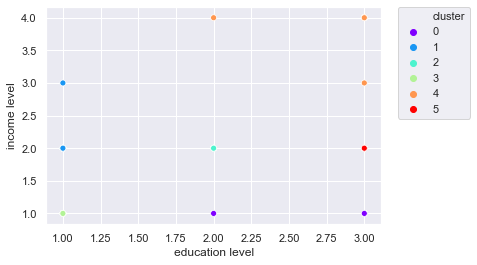

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.scatterplot(x = hood_clusters['education level'],y = hood_clusters['income level'], hue = hood_clusters['cluster'],palette = rainbow)

# moving legend outside of the graph 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [622]:
#add a type to each dataframe to identify if it is a venue or a neighbourhood 
edm_venues['type'] = 1

hood_clusters['type'] = 2
hood_clusters['lat'] = edm_hood_total['Latitude']
hood_clusters['lng'] = edm_hood_total['Longitude']
hood_clusters['Population'] = edm_hood_total['Population']


In [625]:
from sklearn import preprocessing
# add a normalized population column 

# Create x, where x the 'scores' column's values as floats
x = edm_hood_total[['Population']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)


hood_clusters['norm Pop'] = x_scaled

In [626]:
#combine a map of venues and hoodclusters 
edm_venue_and_hood = pd.concat([edm_venues,hood_clusters], sort = True)


In [637]:
edm_venue_and_hood.reset_index(inplace = True)
edm_venue_and_hood

,level_0,index,Neighbourhood Name,Neighbourhood Number,Population,categories,cluster,education level,income level,lat,lng,name,norm Pop,rank,type
0,0,0,NaN,NaN,NaN,Shopping Mall,NaN,NaN,NaN,53.523619,-113.622429,West Edmonton Mall,NaN,1.0,1
1,1,1,NaN,NaN,NaN,Warehouse Store,NaN,NaN,NaN,53.455520,-113.469639,Costco,NaN,1.0,1
2,2,2,NaN,NaN,NaN,Shopping Mall,NaN,NaN,NaN,53.485168,-113.514191,Southgate Centre,NaN,1.0,1
3,3,3,NaN,NaN,NaN,Warehouse Store,NaN,NaN,NaN,53.509590,-113.685265,Costco,NaN,1.0,1
4,4,4,NaN,NaN,NaN,Warehouse Store,NaN,NaN,NaN,53.546811,-113.317404,Costco,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,344,244,Dovercourt,3170.0,2048.0,NaN,1.0,1.0,2.0,53.575727,-113.559534,NaN,0.106620,NaN,2
345,345,245,Ogilvie Ridge,5300.0,1001.0,NaN,4.0,3.0,4.0,53.464904,-113.567069,NaN,0.050041,NaN,2
346,346,246,Woodcroft,3450.0,2598.0,NaN,3.0,1.0,1.0,53.564595,-113.558327,NaN,0.136342,NaN,2
347,347,247,Satoo,6680.0,3391.0,NaN,1.0,1.0,2.0,53.446373,-113.458892,NaN,0.179195,NaN,2


## Finding best path 
### to find the best we will need to calculate the closest point from the current point the following function will do exactly that with a given point and radius 

In [875]:
from math import radians, cos, sin, asin, sqrt
"""
    Haversine function,
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
"""
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.
    km = c * r
    return km * 1000

In [864]:
'''
input dataframe that has columns of lat and lng, and the lat and lng values along with a radius. 
returns a list of lists, the first value of the inner list will be the index in the dataframe
the second value will be the the distance in meters away from the given point 
'''
def closePoints(df,lat,lng,radiusin,radiusout):
    index = 0
    results = []
    for lat2,lng2 in zip(df['lat'],df['lng']):
        distance = haversine(lng,lat,lng2,lat2)
        if (lat == lat2 and lng == lng2):
            index += 1
            continue 
        elif (distance > radiusin and distance < radiusout):
            results.append([distance,index])
        index += 1
    return results


## Making a Heuristic
to find the best path we will have to calculate a heuristic.
this hurstic will be calculated in 2 different catagries.

1. the second will be locations in the city, 
    these will be classified as possible endpoints so the popularity. 
    the huristic will be divied up by rank = 1, h = 1.00, rank = 2, h = 0.75 rank = 3, h = 0.50, rank = 4, h = 0.25

2. the fist will be the neighbourhoods or the type 1 and will be based on the clustering and population
    cluster values are only 0-5 but population values vary a lot will use the normalized value 
    key demographics are high educated low income areas so clusters 0,2,5 are most valued at 1.0
    low income and low education clusters 1 & 3 will be valued the same at 0.75
    high income is not valued as much so cluster 4 will be valued at 0.25
    The total heuristic will be made by adding the population and cluster heuristic 

In [670]:
# pass it a one row dataframe 
def heuristic(df):
    heu = float()
    if df['type'] == 1:
        # destination heuristic 
        r = df['rank']
        if r == 1:
            heu = 1.00
        if r == 2:
            heu = 0.75
        if r == 3:
            heu = 0.50
        if r == 4:
            heu = 0.25
        if r == 5:
            heu = 0.10


    elif df['type'] == 2:
        #neighbourhood heuristic 
        c = df['cluster']
        if c == 0 or c == 2 or c == 5:
            heu = 1.00 + df['norm Pop']
        if c == 1 or c == 3:
            heu = 0.75 + df['norm Pop']
        if c == 4:
            heu = 0.20 + df['norm Pop']

    else:
        print("could not find heuristic for ", df)
        return

    return heu


In [646]:
# getting the starting point closest place to the center of edmonton
start = closePoints(edm_venue_and_hood,latitude,longitude, 500)
print(start)

[[216.90228116175695, 16], [373.11607991931356, 87]]


In [647]:
# starting location will be index 16 
start_loc = start[0]

In [880]:
#issue with to many stations being placed in close proximity 
#this function is a boolean check to see if there is a station within prozimity 
#index is the list of children
def close_station(df,index,new_station,radius):
    for i in index:  
        lat1 = df.loc[i]['lat']
        lon1 =  df.loc[i]['lng']

        lat2 = df.loc[new_station]['lat']
        lon2 =  df.loc[new_station]['lng']

        distance = haversine(lon1, lat1, lon2, lat2)

        
        if distance < radius:
            return 0
        else:
            return 1


## Search Algorithm
#### because there is no specific destination only really a "max line" the loop will stop when a specific amount of links are made, because the current line is about 20 links long i will make this total links around 30. also needed to implement a feature that would prevent a station being placed to close to another station because what is the point of that. 

In [1115]:
'''
parameters: 
    df = dataframe of where the long and lat of all the items are stored 
    start = a single line of a the dataframe df
    children = a list children of the line 
'''
def searcher(df,start,children,links,lines):
    lng = start['lng']
    lat = start['lat']
    nearby = closePoints(df,lat,lng,300,900)
    
    start_index = start['index']
    #remove points that are already in the chain 
    # see what the huristic of the close points are 
    her = np.zeros(len(nearby))
    indexer = 0
    heuris = 0
    for i in nearby: 
        close = close_station(df,children,i[1],100)
        if close == 0:
            indexer += 1
            continue
        if i[1] in children:
            indexer += 1
            continue

        row = df.loc[i[1]]
        heuris = heuristic(row)
        her[indexer] = heuris
        indexer += 1
        
    
    if heuris == 0:
        # go back to last point 
        next_point_index = children[links-1]
        next_point = df.loc[next_point_index]
        links -= 1

    else:
        pick = her.argmax()
        next_point_index = nearby[pick][1]

        children[links-1] = next_point_index

        lines[links-1][0] = start_index
        lines[links-1][1] = next_point_index

        next_point = df.loc[next_point_index]
        links -= 1


    if links > 0:
        #print(next_point_index)
        chain = searcher(df,next_point,children,links,lines)
    
    return children, lines
    

In [1092]:
links = 15
children = np.zeros(links)
lines = np.zeros((links,2))

track1 = searcher(edm_venue_and_hood,start,children,links,lines)
print(track1)

(array([ 83.,  82.,  74.,  77.,  60.,   8.,  63.,  95., 113.,  36.,  18.,
       199.,  87.,  16., 167.]), array([[ 82.,  83.],
       [ 74.,  82.],
       [ 77.,  74.],
       [ 60.,  77.],
       [  8.,  60.],
       [ 63.,   8.],
       [ 95.,  63.],
       [ 13.,  95.],
       [ 36., 113.],
       [ 18.,  36.],
       [ 99.,  18.],
       [ 87., 199.],
       [ 16.,  87.],
       [ 67.,  16.],
       [ 16., 167.]]))


In [1001]:
def index_to_longlat(df,index):
    lat = df.loc[index]['lat']
    lng =  df.loc[index]['lng']
    return [lat,lng]

In [1002]:
def list_of_longlat(df,indexlist):
    long_lat = []
    
    for i in indexlist:
        long_latlist = index_to_longlat(df,i)
        long_lat.append(long_latlist)
    return long_lat

In [1003]:
def mappinglines(map,df,line_list,color):
    for i in line_list:
        start = [0,0]
        end = [0,0]
        start = index_to_longlat(df,i[0])
        end = index_to_longlat(df,i[1])
        folium.PolyLine([start,end], color=color, weight=2.5, opacity=1).add_to(trackmap)


In [1093]:
trackmap = folium.Map(location=[latitude, longitude], zoom_start=11)
mappinglines(trackmap,edm_venue_and_hood,track1[1],'red')

trackmap

 when the start point is placed in the middle of the city the line is scattered in the center but shoots out south and north east this is similar to the actual line that is in the city

![Algorithm map](img/lrtline1.png)

and the actual line that is in the city 

![Actual map](img/edmontonlrt.png)

as you can see they are semi close and my prediction is that they would be closer if foursquare picked up the University of Alberta but currently in the data set that is not a location it would definetly be popular enough to pend the line more west 


## continue
the problem was not to see if the existing line was efficent but to see where the best new line would be to put in. for this i decided to put 4 start points around the city one in the north, south, east and west, then see where the algorithm finds its way to the most important places.

In [1118]:
lnglat = list_of_longlat(edm_venue_and_hood,track1[0])


In [1021]:
def list_lines(df,line_list):
    new_list = []
    for i in line_list:
        start = [0,0]
        end = [0,0]
        start = index_to_longlat(df,i[0])
        end = index_to_longlat(df,i[1])
        new_list.append(start)
        new_list.append(end)
    return new_list
        

In [1116]:
# west start will be west edmonton mall (biggest mall in edmonton)
start_westlnglat = [53.5225, -113.6242]
# south start will be south edmonton common (popular shops)
start_southlnglat = [53.4463,-113.4841]
#east start will be king edward park (no real big venues on the east side)
start_eastlnglat = [53.5157, -113.4529]
#north start will be close to nait(technical school) station already there but it is very bad
start_nothlnglat = [53.6406, -113.5002]


start_west1 = closePoints(edm_venue_and_hood,start_westlnglat[0],start_westlnglat[1], 0,200)

start_south1 = closePoints(edm_venue_and_hood,start_southlnglat[0],start_southlnglat[1], 0,70)

start_east1 = closePoints(edm_venue_and_hood,start_eastlnglat[0],start_eastlnglat[1], 0,300)

start_north1 = closePoints(edm_venue_and_hood,start_nothlnglat[0],start_nothlnglat[1], 0,800)

start_west = edm_venue_and_hood.loc[start_west1[0][1]]
start_south = edm_venue_and_hood.loc[start_south1[0][1]]
start_east = edm_venue_and_hood.loc[start_east1[0][1]]
start_north = edm_venue_and_hood.loc[start_north1[0][1]]

links = 5
linesw = np.zeros((links,2))
liness = np.zeros((links,2))
linese = np.zeros((links,2))
linesn = np.zeros((links,2))

childrenw = np.zeros(links)
childrens = np.zeros(links)
childrene = np.zeros(links)
childrenn = np.zeros(links)

trackw = searcher(edm_venue_and_hood,start_west,childrenw,links,linesw)

links = 5
tracks = searcher(edm_venue_and_hood,start_south,childrens,links,liness)

links = 5
tracke = searcher(edm_venue_and_hood,start_east,childrene,links,linese)

links = 5
trackn = searcher(edm_venue_and_hood,start_north,childrenn,links,linesn)

lnglatW = list_lines(edm_venue_and_hood,trackw[1])
lnglatS = list_lines(edm_venue_and_hood,tracks[1])
lnglatE = list_lines(edm_venue_and_hood,tracke[1])
lnglatN = list_lines(edm_venue_and_hood,trackn[1])

In [1120]:
trackmap = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.PolyLine(lnglatW, color="red", weight=2.5, opacity=1).add_to(trackmap)
folium.PolyLine(lnglatS, color="blue", weight=2.5, opacity=1).add_to(trackmap)
folium.PolyLine(lnglatE, color="green", weight=2.5, opacity=1).add_to(trackmap)
folium.PolyLine(lnglatN, color="orange", weight=2.5, opacity=1).add_to(trackmap)


trackmap

# Final results & Discussion
#### The final results looks more like abstract art then it does a metro line lay out, but there is still some interesting take aways from this result 

![Final map](img/completelrt.png)


#### The first thing to note is even though the red line started at west edmonton mall the north and south lines both make their way toward it, making it a popular location and one that should be taken into accout for the new line. The above image is not that of a best new line but that of the best line for each side of the city, for poeple on the west side the best line would be that of one north of the river that goes downtown. and people on the east side would benifit modt for a line that then goes south and toward downtown. Starting in the south the best most popular routes go north and toward west edmonton mall. The north line splitting at the top shows that picking up greater amount of people is more valuble then getting to a location that is directly downtown. 

# Conclusion 

#### The purpose of this project was to see where the best new lrt line would be,to help the city planers plan the next line in the future. By calculating and clustering the neighbourhood demographics and then creating a pathing algorithm we can show the general path of people of where they live to where they want to be. There are multiple improvments and changes that i would like to implement in the future these are: 
#### The path algorithm still needs some work to smooth out the lines, but the jaged lines still tell a story about where the population is and where they want to go. 
#### More data would also be a massive benifit foursquare is not used that much in Edmonton and the city actually has much better datasets.  
#### many more senerios with start points, even use regression to find optimal start position 



### Thank you for taking the time to read my analysis of the Edmonton LRT system 


